In [52]:
import torch
import torch.utils.data as data
import torch.nn as nn
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")

    # Losowość jest bardzo ważnym elementem trenowania sieci neuronowych (o czym się wkrótce przekonamy).Eksperymentując, chcielibyśmy jednak żeby przy każdym uruchomieniu programu, wynik był taki sam. Tylko w takim przypadku jesteśmy w stanie coś wnioskować. Do zapewnienia możliwości reprodukcji wyników na GPU za pomocą pytorcha służa poniższe komendy:

    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

else:
    device = torch.device("cpu")

print(device.type)

cuda


In [4]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', delimiter=";")

In [51]:
len(df.columns)

12

In [5]:
train=df.sample(frac=0.8,random_state=200) #random state is a seed value
test=df.drop(train.index)

In [6]:
classes = Counter(df["quality"])

In [7]:
df.keys().__len__()

12

<BarContainer object of 7 artists>

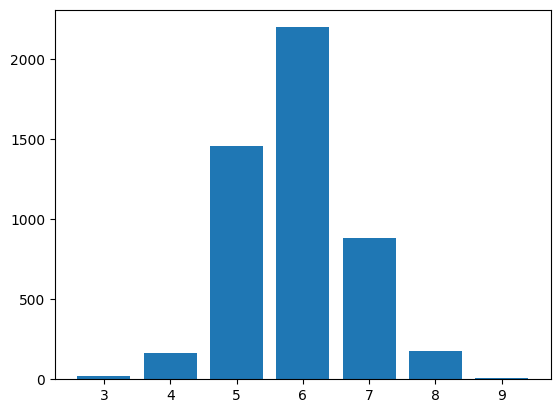

In [8]:
plt.bar(classes.keys(), classes.values())

In [53]:
train_labels = train.values[:, -1].astype(np.int64)
train_labels_mapped = []
for label in train_labels:
    if label < 6:
        train_labels_mapped.append(0)
    elif 5 <= label < 7:
        train_labels_mapped.append(1)
    else:
        train_labels_mapped.append(2)


train_labels = torch.tensor(train_labels_mapped)

scaler = StandardScaler()
train_data = train.values[:,:-1].astype(np.float32)
train_data = scaler.fit_transform(train_data)
#train_labels = nn.functional.one_hot(train_labels, 11)
train_dataset = data.TensorDataset(torch.from_numpy(train_data), train_labels)

dict_keys([0, 1, 2])


<BarContainer object of 3 artists>

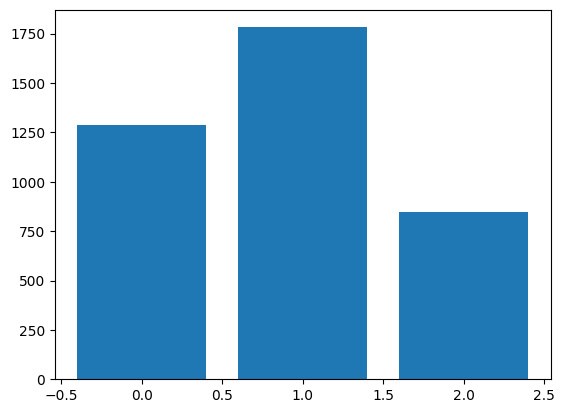

In [54]:
classes = Counter(train_labels_mapped)
print(classes.keys())
plt.bar(classes.keys(), classes.values())

In [104]:
class WineClassifier(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, 512)
        self.act_fn = nn.LeakyReLU()
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = nn.Dropout(p=0.25)(x)
        x = self.linear2(x)
        x = self.act_fn(x)
        x = nn.Dropout(p=0.25)(x)
        x = self.linear3(x)
        return x

In [120]:
train_data_loader = data.DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=10)

In [121]:
model = WineClassifier(11, 3)
model.to(device)

WineClassifier(
  (linear1): Linear(in_features=11, out_features=512, bias=True)
  (act_fn): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=3, bias=True)
)

In [122]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}, dtype {param.dtype}")

Parameter linear1.weight, shape torch.Size([512, 11]), dtype torch.float32
Parameter linear1.bias, shape torch.Size([512]), dtype torch.float32
Parameter linear2.weight, shape torch.Size([128, 512]), dtype torch.float32
Parameter linear2.bias, shape torch.Size([128]), dtype torch.float32
Parameter linear3.weight, shape torch.Size([3, 128]), dtype torch.float32
Parameter linear3.bias, shape torch.Size([3]), dtype torch.float32


In [123]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [124]:
loss_module = nn.CrossEntropyLoss()

In [125]:
# Training loop
EPOCHS = 200
for epoch in range(EPOCHS):
    total_loss = 0
    correct = 0
    total = 0

    model.train()
    for data_inputs, data_labels in train_data_loader:
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

        logits = model(data_inputs)  # No softmax needed
        loss = loss_module(logits, data_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy calculation
        preds = logits.argmax(1)
        correct += (preds == data_labels).sum().item()
        total += data_labels.size(0)

    avg_loss = total_loss / len(train_data_loader)
    accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")

Epoch 1: Loss = 0.9873, Accuracy = 47.96%
Epoch 2: Loss = 0.8967, Accuracy = 57.27%
Epoch 3: Loss = 0.8606, Accuracy = 58.60%
Epoch 4: Loss = 0.8509, Accuracy = 58.91%
Epoch 5: Loss = 0.8398, Accuracy = 59.34%
Epoch 6: Loss = 0.8248, Accuracy = 59.47%
Epoch 7: Loss = 0.8222, Accuracy = 60.16%
Epoch 8: Loss = 0.8193, Accuracy = 60.54%
Epoch 9: Loss = 0.8098, Accuracy = 60.62%
Epoch 10: Loss = 0.8054, Accuracy = 61.20%
Epoch 11: Loss = 0.8021, Accuracy = 61.31%
Epoch 12: Loss = 0.7938, Accuracy = 61.79%
Epoch 13: Loss = 0.7977, Accuracy = 62.20%
Epoch 14: Loss = 0.7896, Accuracy = 62.15%
Epoch 15: Loss = 0.7886, Accuracy = 62.17%
Epoch 16: Loss = 0.7837, Accuracy = 62.15%
Epoch 17: Loss = 0.7773, Accuracy = 62.30%
Epoch 18: Loss = 0.7804, Accuracy = 62.71%
Epoch 19: Loss = 0.7732, Accuracy = 63.30%
Epoch 20: Loss = 0.7730, Accuracy = 62.79%
Epoch 21: Loss = 0.7666, Accuracy = 63.96%
Epoch 22: Loss = 0.7661, Accuracy = 63.53%
Epoch 23: Loss = 0.7676, Accuracy = 63.37%
Epoch 24: Loss = 0.7

In [126]:
test_labels = test.values[:, -1].astype(np.int64)
test_labels_mapped = []
for label in test_labels:
    if label < 6:
        test_labels_mapped.append(0)
    elif 5 <= label < 7:
        test_labels_mapped.append(1)
    else:
        test_labels_mapped.append(2)

test_data = test.values[:,:-1].astype(np.float32)
test_data = scaler.transform(test_data)

test_dataset = data.TensorDataset(torch.from_numpy(test_data), torch.tensor(test_labels_mapped))
test_data_loader = data.DataLoader(test_dataset, batch_size=512, shuffle=False, drop_last=False)
model.eval() # Set model to eval mode
true_preds, num_preds = 0., 0.

with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in test_data_loader:

        # Determine prediction of model on dev set
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
        logits = model(data_inputs)
        pred_probabilites = nn.Softmax(dim=1)(logits)
        pred_labels = pred_probabilites.argmax(1)

        # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
        true_preds += (pred_labels == data_labels).sum()
        num_preds += data_labels.shape[0]

acc = true_preds / num_preds
print(f"Accuracy of the model: {100.0*acc:4.2f}%")

Accuracy of the model: 66.02%
